In [20]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

import tensorflow as tf

import pixiedust
from functools import partial
import gin
import itertools
import multiprocessing
import pickle

from synthetic_data import xs_e, ys_e, Q1, xs, ys, A
from synthetic_experiment import projection_simplex_sort, arr_of_dicts_to_dict_of_arrays
from synthetic_experiment import projection_step, mask_step, compute_mask
from tqdm.notebook import tqdm
import math
import seaborn as sns

from simple_pid import PID


In [9]:
# defining the model
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(2, input_shape=(4,), use_bias=False)
    ])
    return model

# learning rate
lr = 1e-3

# number of epochs
epochs = 2000

# training batch size
batch_size = 128

# maximum weight norm
l1_ball_size = 5

# data
X = xs
Y = ys

In [10]:
# creating an optimizer
optimizer = tf.keras.optimizers.Adam(lr=lr)

In [194]:
@tf.function
def flatten_array_of_tensors(W):
    """Take an array of tensor and turn into a single flat tensor."""
    return tf.concat([tf.reshape(w, (-1,)) for w in W], axis=0)

def gradient_step(xs, ys, model, optimizer):
    """Do a gradient step."""
    
    xs = np.array(xs, dtype=np.float32)
    ys = np.array(ys, dtype=np.float32)
    
    with tf.GradientTape() as tape:
        y_pred = model(xs)
        delta = y_pred - ys
        delta_flat = flatten_array_of_tensors([delta])
        
        # using MAE
        loss = tf.reduce_mean(tf.abs(delta_flat))
        
        # l1 norm of weights
        loss_l1 = tf.reduce_sum(tf.abs(\
                    flatten_array_of_tensors(model.weights)))
    
    variables = model.trainable_variables
    grads = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(grads, variables))
    
    return {'fit': loss.numpy(), 'l1': loss_l1.numpy()}

mask = None

def step(xs, ys, model, optimizer):
    """Optimize 1 step."""
    #print(model.weights)
    losses = gradient_step(xs, ys, model, optimizer)
    #print(model.weights)
    nnz = mask_step(model.weights[0], mask)
    #print(model.weights)
    norm = projection_step(model.weights[0], l1_ball_size)
    losses['l1'] = norm
    losses['nnz'] = nnz
    return losses

In [247]:
def plot_results(losses):
    """Plot losses."""
    fig = plt.figure(figsize=(12, 5))
    fig.patch.set_facecolor('xkcd:mint green')

    references = {'fit': 0, 'l1': l1_ball_size, 'nnz': np.sum(A), 'eps': 0}

    for i, key in enumerate(losses.keys()):
        plt.subplot(1, len(losses) + 1, i + 1)
        plt.title(key)
        plt.plot(losses[key])
        plt.axhline(references[key], ls='--', c='black')
        
    plt.subplot(1, len(losses) + 1, len(losses) + 1)
    plt.title("Weights heatmap")
    sns.heatmap(model.weights[0].numpy())

    plt.show()

In [196]:
def train(model, optimizer, X, Y):
    """Train with batches."""
    losses = []

    batches_per_epoch = math.ceil(1. * len(X) / batch_size)

    for epoch in tqdm(range(epochs)):
        for batch in range(batches_per_epoch):
            n = batch * batch_size
            xs_b = X[n:n+batch_size]
            ys_b = Y[n:n+batch_size]
        l = step(xs_b, ys_b, model, optimizer)
        losses.append(l)
    losses = arr_of_dicts_to_dict_of_arrays(losses)
    return losses

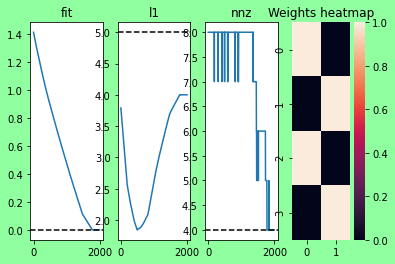

In [18]:
l1_ball_size = 5
mask = None
model = build_model()
losses = train(model, optimizer, X, Y)
plot_results(losses)

## PID demo

In [118]:
# dynamical system

state = [0, 0]

def reset():
    return [0, 0]

def update(state, control):
    x, v = state
    v += control * dt
    x += v * dt + control * dt ** 2 / 2
    return [x, v]

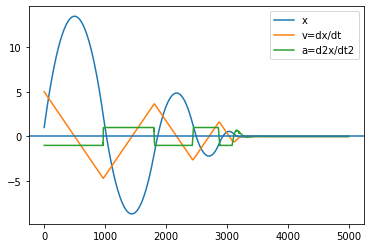

In [127]:
# interaction demo

xs = []
vs = []
as_ = []

pid = PID(5, 0.1, 5e-4, setpoint=0)
pid.sample_time = 0
pid.output_limits = (-1, 1)

state = reset()

state[0] = 1
state[1] = 5

for _ in range(5000):
    x, v = state
    control = pid(float(x))
    state = update(state, control)
    xs.append(x)
    vs.append(v)
    as_.append(control)
    
plt.figure()
plt.plot(xs, label='x')
plt.plot(vs, label='v=dx/dt')
plt.plot(as_, label='a=d2x/dt2')
plt.legend()

plt.axhline(0)

plt.show()

## Generating  multicollinear features xs + xs_e

In [148]:
add_features = 10

In [314]:
N = 5000
dim1 = 4
dim2 = 10
xs = np.random.randn(N, dim1)
ys = np.sum(xs, axis=1)

eps_noise = 1e-2

confusion = np.random.randn(dim2, dim1)
xn = (confusion @ xs.T).T
xn += np.random.randn(*xn.shape) * eps_noise
xs_new = np.hstack((xs, xn))
xs = xs_new

dim = dim1 + dim2

ys = ys.reshape((-1, 1))

In [328]:
# defining the model
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(1, input_shape=(dim,), use_bias=False, activation=None)
    ])
    return model

# learning rate
lr = 1e-3

# number of epochs
epochs = 200000

# training batch size
batch_size = 128

# maximum weight norm
l1_ball_size = 5

# data
X = xs
Y = ys

In [316]:
np.sum(np.sum(xs[:, :dim1], axis=1) - ys)

1.013177097775042e-09

In [330]:
def step(xs, ys, model, optimizer):
    """Optimize 1 step."""
    #print(model.weights)
    global mask
    losses = gradient_step(xs, ys, model, optimizer)
    
    if use_pid:
        fit_loss = losses['fit']
        eps = pid(-fit_loss)
        losses['eps'] = eps
        if eps >= 1 - 1e-1:
            mask = compute_mask(model.weights[0].numpy(), dim1)
            pid_reset()
        if mask is not None:
            mask[mask < 1] = eps
        
    
    #print(model.weights)
    nnz = mask_step(model.weights[0], mask)
    #print(model.weights)
    norm = projection_step(model.weights[0], l1_ball_size)
    losses['l1'] = norm
    losses['nnz'] = nnz
    return losses

In [331]:
def plot_results(losses):
    """Plot losses."""
    fig = plt.figure(figsize=(12, 5))
    fig.patch.set_facecolor('xkcd:mint green')

    references = {'fit': 0, 'l1': l1_ball_size, 'nnz': np.sum(A), 'eps': 0}

    for i, key in enumerate(losses.keys()):
        plt.subplot(1, len(losses) + 1, i + 1)
        plt.title(key)
        plt.plot(losses[key])
        plt.axhline(references[key], ls='--', c='black')
        
    plt.subplot(1, len(losses) + 1, len(losses) + 1)
    plt.title("Weights heatmap")
    cm = sns.diverging_palette(255, 133, l=60, n=20, center="dark")
    sns.heatmap(model.weights[0].numpy(), vmin=-1, vmax=1, cmap=cm)

    plt.show()

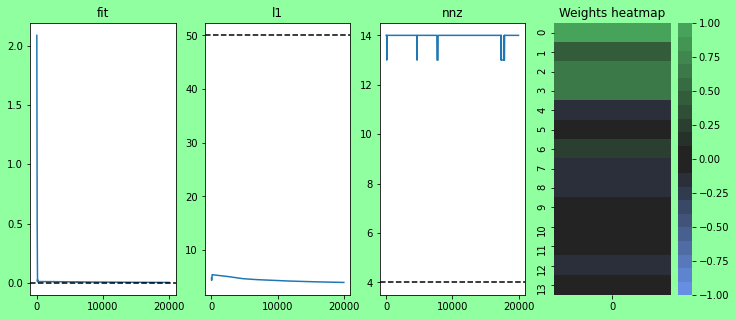

In [319]:
l1_ball_size = 50
batch_size = 512
mask = None
use_pid = False
model = build_model()
losses = train(model, optimizer, X, Y)
plot_results(losses)

In [320]:
mask = compute_mask(model.weights[0].numpy(), dim1)
mask.T

array([[1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

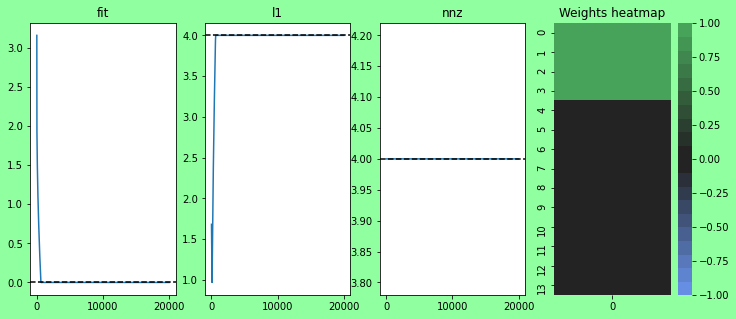

In [321]:
l1_ball_size = dim1 * 2 # in real setup, we don't know the ball size as decoder can have diff. scale
model = build_model()
losses = train(model, optimizer, X, Y)
plot_results(losses)

In [332]:
pid = None
def pid_reset():
    global pid
    pid = PID(1, 0.5, 0, setpoint=0)
    pid.sample_time = 0
    pid.output_limits = (0, 1)

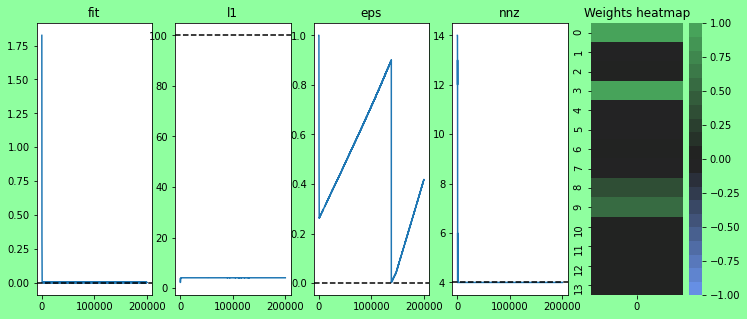

In [333]:
l1_ball_size = 100
mask = None
pid_reset()
use_pid = True
model = build_model()
losses = train(model, optimizer, X, Y)
plot_results(losses)